# 實際驗證


### 我的模型效果


前 100 張圖片


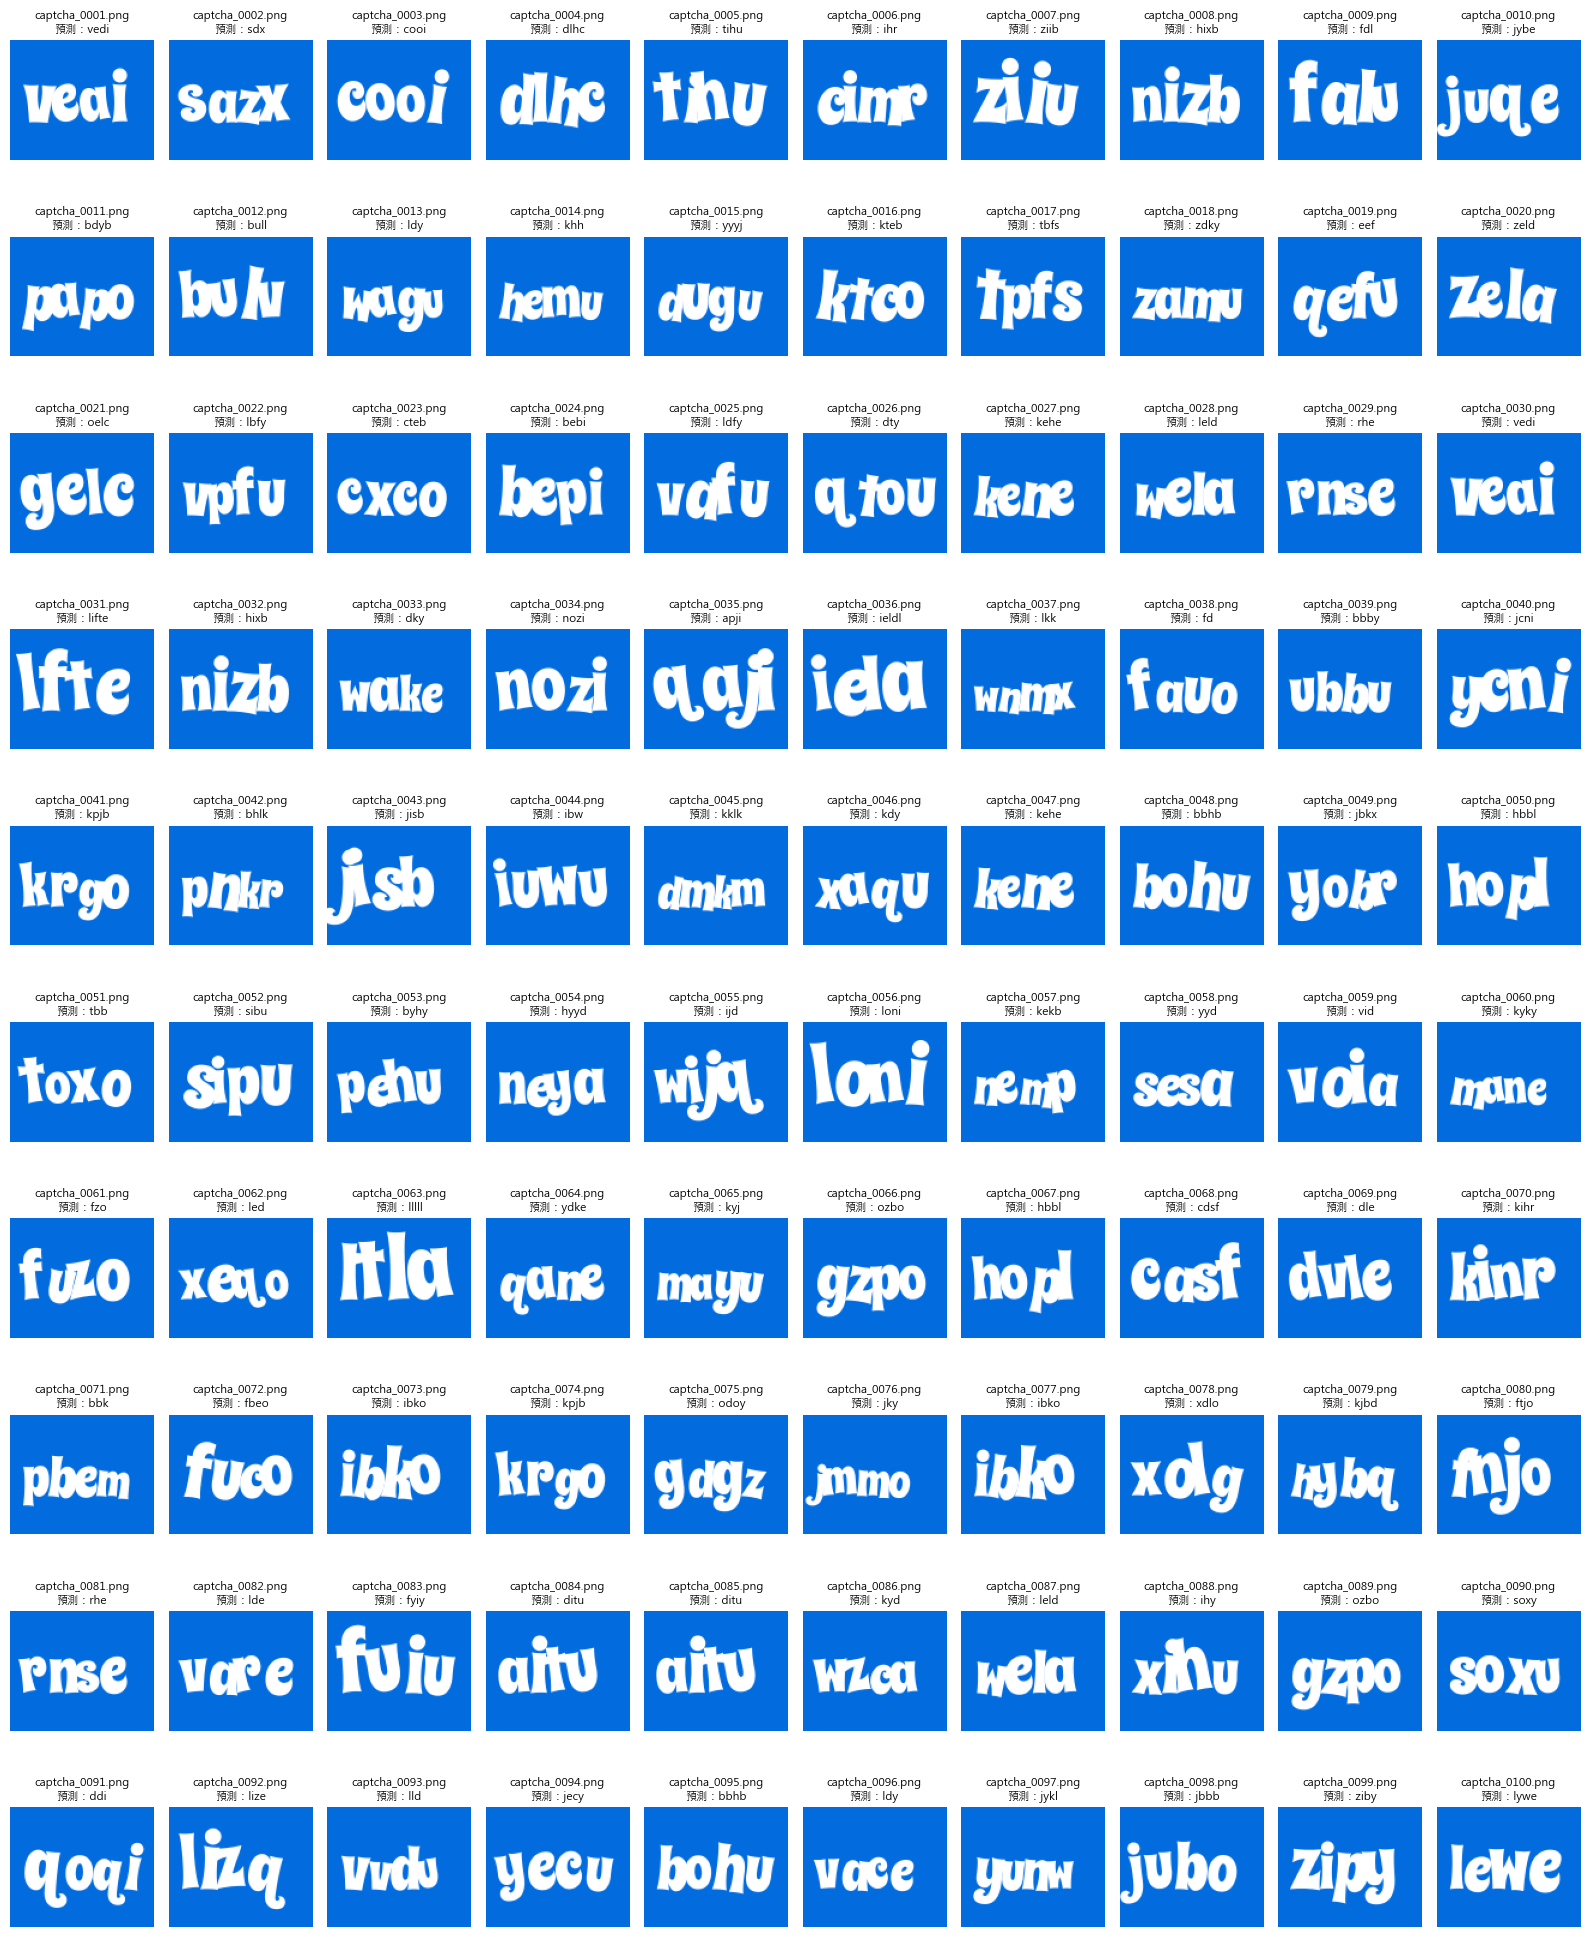

In [1]:
import sys
from pathlib import Path
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import math

# 設定 matplotlib 使用支援中文的字型
plt.rcParams["font.family"] = "Microsoft JhengHei"
plt.rcParams["axes.unicode_minus"] = False

# 加入專案根目錄到匯入路徑中
BASE_DIR = Path("..").resolve()
sys.path.append(str(BASE_DIR))

from src.model.model import CaptchaModel
from src.model.utils import CHARACTER_SET, decode_prediction

# 設定路徑
CRAWLER_IMG_DIR = Path("..") / "data" / "captcha_crawler"
MODEL_PATH = Path("..") / "models" / "ocr_model.pth"

# 載入模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CaptchaModel(num_classes=len(CHARACTER_SET))
state_dict = torch.load(MODEL_PATH, map_location=device, weights_only=True)
model.load_state_dict(state_dict)
model = model.to(device).eval()

# 圖片轉換流程
transform = transforms.Compose(
    [
        transforms.Grayscale(),
        transforms.Resize((100, 120)),
        transforms.ToTensor(),
    ]
)


# 預測函式
def predict_image(image_path: Path):
    image = Image.open(image_path).convert("RGB")
    x = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(x).log_softmax(2).permute(1, 0, 2)
    return decode_prediction(output)[0]


# 取得圖片列表
image_paths = sorted(
    list(CRAWLER_IMG_DIR.glob("*.png")) + list(CRAWLER_IMG_DIR.glob("*.jpg"))
)
print(f"前 {len(image_paths)} 張圖片")


# 顯示前 100 張圖片與預測結果
def show_predictions_100(start_idx=0):
    batch_paths = image_paths[start_idx : start_idx + 100]
    n = len(batch_paths)
    cols = 10
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.6, rows * 2))
    axes = axes.flatten()

    for i, img_path in enumerate(batch_paths):
        pred = predict_image(img_path)
        img = Image.open(img_path).convert("RGB")
        axes[i].imshow(img)
        axes[i].set_title(f"{img_path.name}\n預測：{pred}", fontsize=8)
        axes[i].axis("off")

    # 將多餘的 subplot 關閉
    for j in range(n, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


# 顯示前 100 張
show_predictions_100(start_idx=0)

### 使用 `ddddocr` 效果


前 100 張圖片


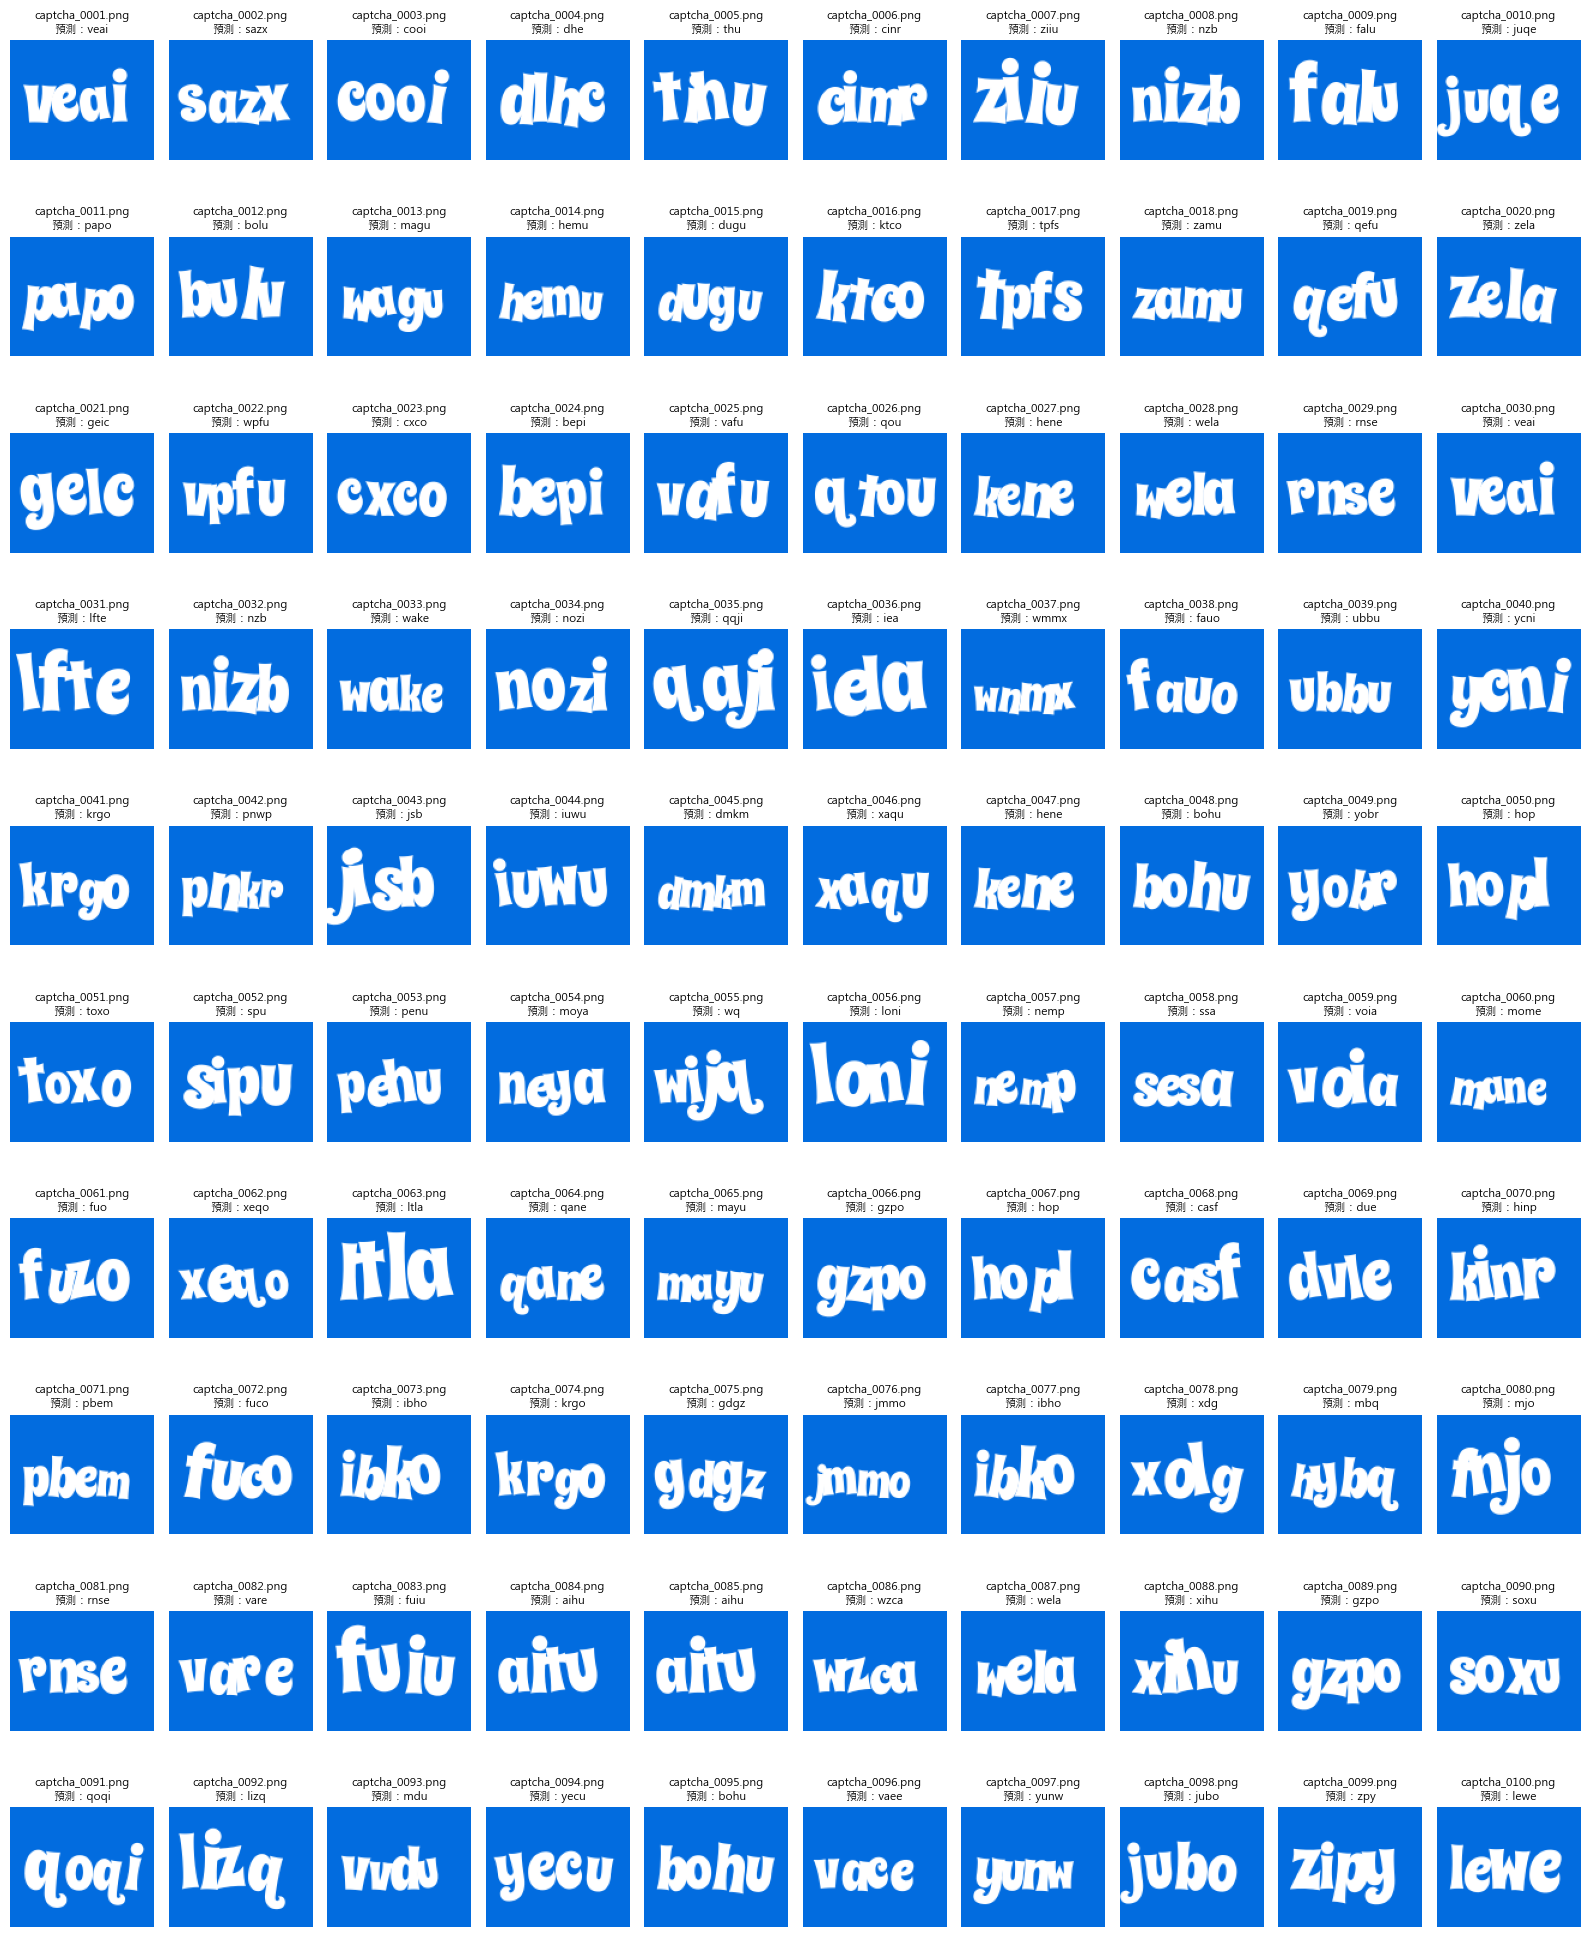

In [2]:
import ddddocr
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import math

# 初始化 OCR
ocr = ddddocr.DdddOcr(show_ad=False)

# 路徑設定
IMG_DIR = Path("..") / "data" / "captcha_crawler"
image_paths = sorted(list(IMG_DIR.glob("*.png")) + list(IMG_DIR.glob("*.jpg")))
print(f"前 {len(image_paths)} 張圖片")


# 單張圖片預測
def predict_image_ddddocr(img_path: Path):
    with open(img_path, "rb") as f:
        img_bytes = f.read()
    return ocr.classification(img_bytes)


# 顯示一批圖片與預測結果（100 張）
def show_ddddocr_predictions(start_idx=0):
    batch_paths = image_paths[start_idx : start_idx + 100]
    n = len(batch_paths)
    cols = 10
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.6, rows * 2))
    axes = axes.flatten()

    for i, img_path in enumerate(batch_paths):
        pred = predict_image_ddddocr(img_path)
        img = Image.open(img_path).convert("RGB")
        axes[i].imshow(img)
        axes[i].set_title(f"{img_path.name}\n預測：{pred}", fontsize=8)
        axes[i].axis("off")

    # 隱藏多餘的 subplot
    for j in range(n, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


# 顯示前 100 張
show_ddddocr_predictions(start_idx=0)